In [181]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import pprint
from pickle import dump, load

pp = pprint.PrettyPrinter(indent=4)

In [183]:
from skimage.io import imread
from skimage.transform import resize
from pathlib import Path
from os import PathLike
# (10 pkt.)
# Funkcja do przerabiania obrazków na dane wejściowe 


# Output - Słownik z przerobionymi obrazami na dane wejściowe zapisz do pliku 
# [nazwa]_[szerokosc]x[wysokosc]px.pkl - aby na przyszlosc pamietac, do jakich rozmiarow zmienilismy obrazki

def resize_all(src: str | PathLike | Path, pklname: str, include: set[str], width=150, height=None) -> Path:
    """
      
    Parameter
    ---------
    src: str
        ściezka do folderu głównego z obrazkami
    pklname: str
        nazwa pliku wyjściowego
    width: int
        docelowa szerokość obrazków 
    include: set[str]
        set zawierający nazwy klas, które chcemy dodać
    """
    src = Path(src)
    include = {x.lower() for x in include}
    
    # Jeśli height nie jest zdefiniowane to przyjmujemy, ze obraz jest kwadratem
    height = height if height else width
     
    data = dict()
    data['description'] = "Zdjęcia"
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # Przechodzimy się po folderze głownym
    for animal_dir in src.iterdir():
        # print(animal_dir)
        if not animal_dir.is_dir() or not animal_dir.name.removesuffix("Head").lower() in include:
            continue

        # Nastepnie przechodzimy się po folderach wewnątrz
        label = animal_dir.name.removesuffix("Head")
        for img_path in [p for p in animal_dir.iterdir() if p.suffix in [".jpg", ".png"]]:
            # Jeśli zdjęcie jest jpg lub png
            # Nastepnie przechodzimy się po zdjęciach
            # to Dzialamy na nie funkcją imread
            img: np.ndarray = imread(img_path)
            # potem dzialamy funkcją resize
            img: np.ndarray = resize(img, (width, height))

            # Do słownika dodajemy nazwę klasy
            # Do słownika dodajemy nazwę pliku
            # Do słownika dodajemy odczytany i pomniejszony obraz
            data['label'].append(label)
            data['filename'].append(img_path.name)
            data['data'].append(img)

    with open(pklname, 'wb') as f:
        # Cały słownik "piklujemy"
        dump(data, f)
    
    print(f"Zapisano dane do pliku {pklname}")

    return Path(pklname)


In [184]:
# (5 pkt.)

pkl_name = "out"
width = 80
 
include = {'Cow', 'Monkey', 'Pigeon', }
        #    'Eagle', 'Deer', 'Monkey', 'Panda'}
 
# wywołaj funkcję - resize_all
# resize_all(os.)
pkl_path = resize_all("Image", pkl_name, include, width)


Zapisano dane do pliku out_80x80px.pkl


In [185]:
from collections import Counter
# (5 pkt.)
# Załaduj "zapiklowany" plik

with open(pkl_path, 'rb') as f:
    data = load(f)

# Wypisz informacje o zapiklowanym słowniku
 
print('Ilość próbek: ',  len(data['data']))
print('Klucze zapiklowanego słownika: ', list(data.keys()))
print('Shape pojedynczego zdjęcia: ', data['data'][0].shape)
print('Labels: ', set(data['label']))
print('Liczba klas: ', dict(Counter(data['label'])))

# Napisz w komentarzu, co odpowiada za shape zdjęcia

Ilość próbek:  299
Klucze zapiklowanego słownika:  ['description', 'label', 'filename', 'data']
Shape pojedynczego zdjęcia:  (80, 80, 3)
Labels:  {'Pigeon', 'Cow', 'Monkey'}
Liczba klas:  {'Cow': 101, 'Monkey': 100, 'Pigeon': 98}


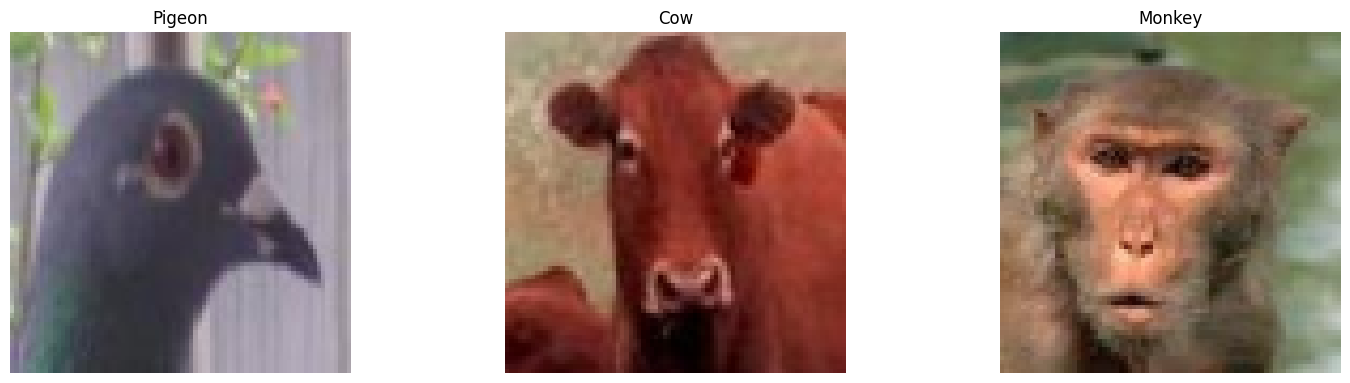

In [186]:
# Printowanie zdjęć (po jednym z kadej klasy)
# (5 pkt.)
# unikalna lista klas
labels = list(set(data['label']))
 
# Ustawienia matplot lib
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 

# Dla kazdego utworzonego wcześniej pustego okienka na zdjęcie oraz podpis pod nim:
for ax, label in zip(axes, labels):

    # W miejscu komentarza któreś ze zdjęć danej klasy
    ax.imshow(data['data'][data['label'].index(label)])
    ax.axis('off')
    ax.set_title(label)

In [187]:
# Utwórz zbiór cech oraz klas
# (pkt.)
X = np.array(data['data'])
y = np.array(data['label'])

In [188]:
# Podziel zbiory na treningowy oraz testowy za pomocą gotowej funkcji (poprzednie zajęcia)
# (2 pkt.)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Text(0.5, 1.0, 'Zbiór treningowy')

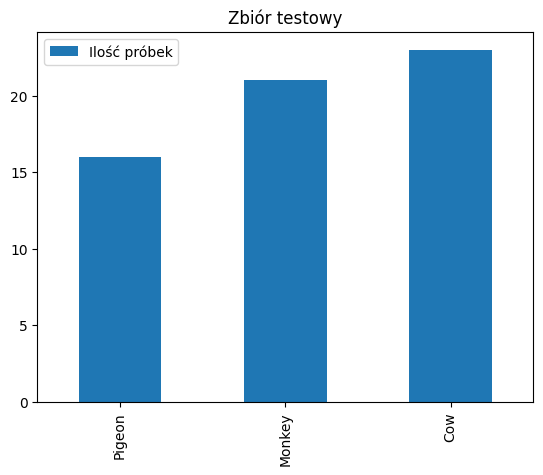

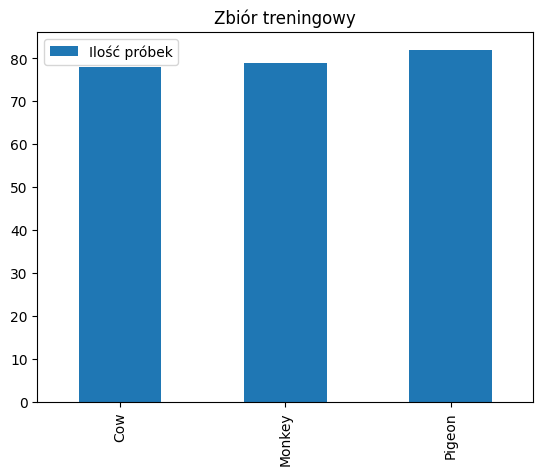

In [189]:
# (5 pkt.)
import pandas as pd

# Pokaz za przy pomocy pandas i matplotlib wykresy, na którym widoczna będzie ilość próbek dla kazdej klasy (czy zbior jest zbalansowany?)
pd.DataFrame(Counter(y_test), index=['Ilość próbek']).T.plot.bar().set_title('Zbiór testowy')
pd.DataFrame(Counter(y_train), index=['Ilość próbek']).T.plot.bar().set_title('Zbiór treningowy')


In [190]:
# Jedynie uruchomić - nie zmieniać 

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
from skimage.feature import hog
import skimage
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Konwertuje RGB do Gray
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Hog features - przyjmuje obrazy juz z 1 channel-em
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()

In [191]:

# (5 pkt.)

# Aby dane mogły być danymi wejściowymi do modelu
# Nalezy najpierw:
#  1. Przetransponować je na skalę szarości
#  2. "Usunąć ze zdjęcia nadmiar szczegółów" za pomocą HOG
#  3. Znormalizować dane

X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(239, 576)


In [192]:
# (5 pkt.)

sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
# Wytrenuj model
sgd_clf.fit(X_train_prepared, y_train)
###

SGDClassifier(random_state=42)

In [193]:
# (5 pkt.)

### Zmodyfikuj zbiór testowy, aby był tak samo zmodyfikowany jak zbiór treningowy i dokonaj predykcji
X_test_gray = grayify.fit_transform(X_test, y_test)
X_test_hog = hogify.fit_transform(X_test_gray, y_test)
X_test_prepared = scalify.fit_transform(X_test_hog, y_test)

y_pred = sgd_clf.predict(X_test_prepared)
y_pred

array(['Pigeon', 'Pigeon', 'Monkey', 'Cow', 'Cow', 'Pigeon', 'Pigeon',
       'Monkey', 'Pigeon', 'Monkey', 'Cow', 'Monkey', 'Monkey', 'Monkey',
       'Cow', 'Cow', 'Monkey', 'Monkey', 'Cow', 'Monkey', 'Monkey',
       'Monkey', 'Pigeon', 'Cow', 'Cow', 'Pigeon', 'Pigeon', 'Monkey',
       'Pigeon', 'Pigeon', 'Cow', 'Pigeon', 'Cow', 'Cow', 'Cow', 'Cow',
       'Monkey', 'Monkey', 'Monkey', 'Cow', 'Cow', 'Cow', 'Monkey', 'Cow',
       'Monkey', 'Monkey', 'Pigeon', 'Pigeon', 'Pigeon', 'Monkey',
       'Monkey', 'Monkey', 'Cow', 'Pigeon', 'Pigeon', 'Monkey', 'Pigeon',
       'Cow', 'Monkey', 'Cow'], dtype='<U6')

In [194]:
# (5 pkt.)

## precision, recall, f1, confusion_matrix, Accuracy
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score

print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


0.9317988064791134
0.9356884057971014
0.9312896405919662
0.9333333333333333
[[20  1  2]
 [ 0 21  0]
 [ 0  1 15]]


In [195]:
def prepare_img(img_dir: str | Path | PathLike, width: int, height=None):
    height = height if height else width

    imgs = list()    
    for img_path in Path(img_dir).iterdir():
        img = imread(img_path)
        img = resize(img, (width, height))
        imgs.append(img)
    
    
    data = np.array(imgs[::])
    data = grayify.fit_transform(data)
    data = hogify.fit_transform(data)
    data = scalify.fit_transform(data)
    
    return (imgs, data)
        

In [196]:
# (10 pkt.)

## Znajdź w sieci 10 obrazków zwierząt, a następnie dokonaj na nich predykcji wcześniej wytrenowanym modelem
imgs, data = prepare_img("TestImg", 80)

In [197]:
preds = sgd_clf.predict(data)
preds

array(['Cow', 'Monkey', 'Monkey', 'Cow', 'Pigeon', 'Pigeon'], dtype='<U6')

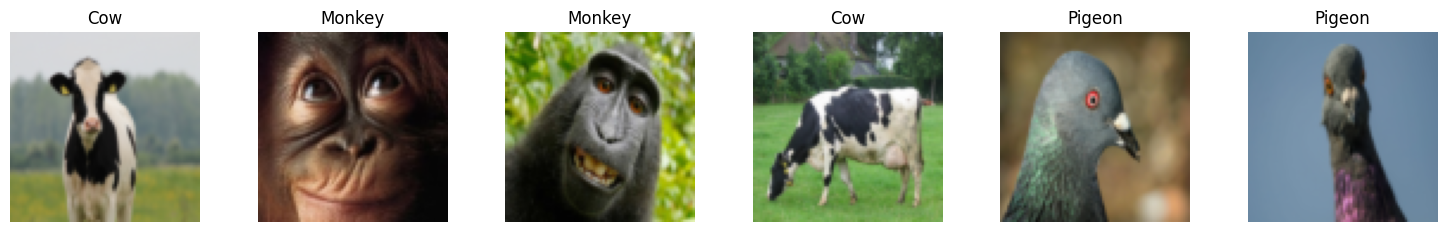

In [198]:
fig, axes = plt.subplots(1, len(preds))
fig.set_size_inches(15,4)
fig.tight_layout()

for i,ax in enumerate(axes):

    # W miejscu komentarza któreś ze zdjęć danej klasy
    ax.imshow(imgs[i])
    ax.axis('off')
    ax.set_title(preds[i])
